In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from tqdm import tqdm
from scipy import ndimage

In [2]:
import torch.nn.functional as F
import torch as tc
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from helpers_img import *
from NeuralNets import *
from training_NN import *
from preprocessing import *

# Valerio inizia da qui

In [ ]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
N = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(N) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(N)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(N) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(N)]
print(files[0])

#n = 85 # Only use 85 images for training

In [3]:
class DatasetUNet(tc.utils.data.Dataset):
    def __init__(self, root_dir, bound=None, do_prep=False, do_flip = False,
                 normalize = False, noise=False, is_simple_noise=False, rot = False):
        self.image_dir = root_dir + "images/"
        self.files = os.listdir(self.image_dir)
        self.gt_dir = root_dir + "groundtruth/"
        self.do_prep = do_prep
        self.do_flip = do_flip
        self.normalize = normalize
        self.noise = noise
        self.is_simple_noise = is_simple_noise
        self.rot = rot
        if bound!=None:
            del self.files[0:bound[0]]
            del self.files[bound[1]:]
    
    def __len__(self):
        return len(self.files)
    
    def true_len(self):
        return len(self.files)*(1+3*self.rot)*(1+1*self.noise)*(1+1*self.do_flip)
    
    def __getitem__(self, index):
        image = load_image(self.image_dir + self.files[index])
        gt_image = load_image(self.gt_dir + self.files[index])
        if self.do_prep:
            _, laplacian_image = add_laplacian(image)
            sobel = add_sobel(image)
            segment = add_segment(image)
            image=np.concatenate((image,laplacian_image,sobel,segment),axis = 2)
        image,gt_image=[image],[gt_image]
        if self.rot:
            image,gt_image = rotation(image,gt_image)
        if self.do_flip:
            image,gt_image = flip(image,gt_image)
            
        image,gt_image = self.from_list_to_tensor(image), self.from_list_to_tensor(gt_image)
        
        if self.normalize:
            image = (image - image.mean())/image.std()
        
        if self.noise:
            image,gt_image = self.add_noise(image, gt_image, is_simple=self.is_simple_noise)
        
        return image,gt_image
    
    def from_list_to_tensor(self,dataset):
        ''' cast a list of image in a tensor of appropriate size'''
        dataset = np.array(dataset)
        try :
            N,rows,columns,features = dataset.shape
        except:
            N,rows,columns = dataset.shape
            features=1
            dataset=dataset.reshape(N,rows,columns,features)

        dataset_tensor = tc.Tensor(N, features, rows, columns)
        for j in range(N):
            dataset_tensor[j] = tc.tensor(np.array([dataset[j,:,:,i] for i in range(features)]))


        return dataset_tensor
        
    def add_noise(self, dataset,label, is_simple=True):
        '''Add noise to the dataset.

        dataset : tensor type

        label : tensor type'''


        if is_simple:

            mean, std = dataset.mean(), dataset.std()
            # the noise has the 20% of the image standard deviation
            noise = np.random.normal(loc = mean, scale = std/5, size = dataset.size())


            dataset_with_noise = dataset + tc.tensor(noise).type(tc.FloatTensor)
            dataset = tc.cat((dataset,dataset_with_noise),dim = 0)
            label = label.type(tc.FloatTensor)
            label = tc.cat((label, label), dim = 0)
        else:

            mean, std = 0, 0.05

            noise = np.random.normal(mean, std, size = label.size())

            label.type(float)

            label_with_noise = label + tc.tensor(noise).type(tc.FloatTensor)

            label = tc.cat((label,label_with_noise),dim=0)

            dataset = tc.cat((dataset,dataset),dim=0)

        return dataset, label
    
    def get_features(self):
        if self.do_prep:
            features = 10
        else:
            features = 3
        return features
    def get_mini(self):
        return (1+3*self.rot)*(1+1*self.do_flip)*(1+1*self.noise)



In [4]:
class Testset(tc.utils.data.Dataset):
    def __init__(self, root_dir, nb_test_imgs, do_prep = False, normalize=False):
        self.root_dir = root_dir
        self.nb_test_imgs = nb_test_imgs
        self.normalize = normalize
        self.do_prep = do_prep
    def __getitem__(self,index):
        dir_test = self.root_dir + 'test_'+str(index+1)+'/'
        files_test = os.listdir(dir_test)
        img_test = load_image(dir_test + files_test[0])
        original_img = img_test
        if self.do_prep:
            _, laplacian_image = add_laplacian(img_test)
            sobel = add_sobel(img_test)
            segment = add_segment(img_test)
            img_test=np.concatenate((img_test,laplacian_image,sobel,segment),axis = 2)
        img_test = self.from_list_to_tensor([img_test])
        if self.normalize:
            img_test = (img_test-img_test.mean())/img_test.std()
        return img_test, original_img
    def __len__(self):
        return self.nb_test_imgs
    
    def from_list_to_tensor(self,dataset):
        ''' cast a list of image in a tensor of appropriate size'''
        dataset = np.array(dataset)
        try :
            N,rows,columns,features = dataset.shape
        except:
            N,rows,columns = dataset.shape
            features=1
            dataset=dataset.reshape(N,rows,columns,features)

        dataset_tensor = tc.Tensor(N, features, rows, columns)
        for j in range(N):
            dataset_tensor[j] = tc.tensor(np.array([dataset[j,:,:,i] for i in range(features)]))


        return dataset_tensor
    
    def get_features(self):
        if self.do_prep:
            features = 10
        else:
            features = 3
        return features

In [ ]:
# Loaded a set of images
root_dir_test = "test_set_images/"
imgs_test = []
for l in range(1,51):
    dir_test = root_dir_test + 'test_'+str(l)+'/'
    files_test = os.listdir(dir_test)
    img_test = load_image(dir_test + files_test[0])
    imgs_test.append(img_test)


In [ ]:
print(next(a))

In [ ]:
image = imgs[0]
plt.figure(figsize=(10,10))
plt.imshow(image)


In [ ]:
mean = image.mean()
std = image.std()

noise = np.random.normal(mean,std/5,size = image.shape)
image_noise = image + noise
plt.figure(figsize=(10,10))
plt.imshow(image_noise)

In [ ]:
# augment the dataset adding rotated images
imgs, gt_imgs = rotation(imgs, gt_imgs)
print('Total number of imgages: '+str(len(imgs)))

# The U-Net

In [5]:
class UNet(tc.nn.Module):
    def __init__(self,features=3):
        super(UNet,self).__init__()
        self.is_training=False
        self.conv1 = tc.nn.Conv2d(features,8,kernel_size=3)
        self.batch1 = tc.nn.BatchNorm2d(8)
        self.conv2 = tc.nn.Conv2d(8,8, kernel_size=3)
        self.batch2 = tc.nn.BatchNorm2d(8)
        self.conv3 = tc.nn.Conv2d(8,16, kernel_size=3)
        self.batch3 = tc.nn.BatchNorm2d(16)
        self.conv4 = tc.nn.Conv2d(16,16, kernel_size=3)
        self.batch4 = tc.nn.BatchNorm2d(16)
        self.conv5 = tc.nn.Conv2d(16,16, kernel_size=4)
        self.batch5 = tc.nn.BatchNorm2d(16)
        self.convUp1 = tc.nn.ConvTranspose2d(16,16,stride=2,kernel_size=2)
        self.conv6 = tc.nn.Conv2d(32,16, kernel_size=3)
        self.batch6 = tc.nn.BatchNorm2d(16)
        self.conv7 = tc.nn.Conv2d(16,16, kernel_size=3)
        self.batch7 = tc.nn.BatchNorm2d(16)
        self.convUp2 = tc.nn.ConvTranspose2d(16,8,stride=2,kernel_size=2)
        self.conv8 = tc.nn.Conv2d(16,8, kernel_size=3)
        self.batch8 = tc.nn.BatchNorm2d(8)
        self.conv9 = tc.nn.Conv2d(8,8, kernel_size=3)
        self.batch9 = tc.nn.BatchNorm2d(8)
        self.convUp3 = tc.nn.ConvTranspose2d(8,4,kernel_size=39)
        self.conv10 = tc.nn.Conv2d(4,1,kernel_size=3)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.relu(self.conv2(x))
        #x1 = x.clone()
        x1 = x
        x = F.max_pool2d(x, kernel_size=2)
        x = x = self.batch2(x)
        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        x = F.relu(self.conv4(x))
        #x2 = x.clone()
        x2 = x
        x = F.max_pool2d(x, kernel_size=2)
        x = self.batch4(x)
        x = F.relu(self.conv5(x))
        x = self.batch5(x)
        
        x = F.relu(self.convUp1(x))
        
        x= self.adapt_activation(x2,x)
        
        x = F.relu(self.conv6(x))
        x = self.batch6(x)
        x = F.relu(self.conv7(x))
        x = self.batch7(x)
        
        x = F.relu(self.convUp2(x))
        
        x = self.adapt_activation(x1,x)
        
        x = F.relu(self.conv8(x))
        x = self.batch8(x)
        x = F.relu(self.conv9(x))
        x = self.batch9(x)
        
        x = F.relu(self.convUp3(x))
        x = tc.sigmoid(self.conv10(x))
        
        return x
    
    def adapt_activation(self,x_old,x_new):
        '''the function adapts the activation to the smaller one dimensions
        and concatenates them'''
        
        space = (x_old.size(2)- x_new.size(2))//2
        
        distance = x_new.size(2)
        
        x_old = x_old.narrow(2,space,distance)
        x_old = x_old.narrow(3,space,distance)
        
        x_new = tc.cat((x_old,x_new),dim=1)
        
        return x_new
        
        
        

In [6]:
def preprocessing_for_UNet(dataset):
    # laplace
    
    for i,image in enumerate(dataset):
        _, laplacian_image = add_laplacian(image)
        sobel = add_sobel(image)
        segment = add_segment(image)
        dataset[i]=np.concatenate((image,laplacian_image,sobel,segment),axis = 2)
    
    return dataset

In [ ]:
def from_list_to_tensor(dataset):
    ''' cast a list of image in a tensor of appropriate size'''
    dataset = np.array(dataset)
    try :
        N,rows,columns,features = dataset.shape
    except:
        N,rows,columns = dataset.shape
        features=1
        dataset=dataset.reshape(N,rows,columns,features)
        
    dataset_tensor = tc.Tensor(N, features, rows, columns)
    for j in range(N):
        dataset_tensor[j] = tc.tensor(np.array([dataset[j,:,:,i] for i in range(features)]))
    
    
    return dataset_tensor

In [7]:
def train_UNet(training_directory, lr, max_epochs, mini_batch_size, nb_test, threshold=0.5, 
               do_preprocessing = False, flip_data=True, model=None, model_path = 'Model_UNet/model_CPU.pt'):
    ''' train the UNet using the Binary Cross Entropy loss and Adam as optimizer.
    The dataset must be a list of 400*400 images.'''
    
    dataset = DatasetUNet(training_directory, bound=(0,-nb_test) ,do_flip=flip_data,
                          do_prep= do_preprocessing,
                          noise=True, is_simple_noise = True, rot = True, normalize = True)
    N = dataset.__len__()+ nb_test
    test_set = DatasetUNet(training_directory, bound=(N-nb_test,N) ,do_flip=False,
                           do_prep= do_preprocessing,
                           noise=False, is_simple_noise = False, rot = False, normalize = True)
    train_load = tc.utils.data.DataLoader(dataset,batch_size= mini_batch_size)
    test_load = tc.utils.data.DataLoader(test_set,batch_size=nb_test)
    if model == None:
        model = UNet(features= dataset.get_features())
    
    optimizer=tc.optim.Adam(model.parameters(),lr)
    # maybe using MSE is better
    #criterion= tc.nn.BCELoss()
    criterion = tc.nn.MSELoss()
    training_errors=[]
    losses=[]
    
    if tc.cuda.is_available():
        print('cuda is available')
        model.cuda()
        #criterion.cuda()
        #dataset= dataset.cuda()
        #label = label.cuda()
    
    #training_F1_error=[]
    #print('starting to train the net')
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #if tc.cuda.is_available():
        #    model.cuda()
        for input_data, label_data in train_load:
            input_data = input_data.view(dataset.get_mini()*mini_batch_size,dataset.get_features(),400,400)
            label_data = label_data.view(dataset.get_mini()*mini_batch_size,1,400,400)
            if tc.cuda.is_available():
                input_data, label_data = input_data.cuda(), label_data.cuda()
            output = model(input_data)
            #print(output, label_data)
            loss = criterion(output, label_data)
            model.zero_grad()
            loss.backward()
            optimizer.step()
            tc.cuda.empty_cache()
            
        
        # compute training error
        model.eval()
        losses.append(loss)
        for test,mask in test_load:
            test = test.view(test_set.get_mini()*nb_test,test_set.get_features(),400,400)
            mask = mask.view(test_set.get_mini()*nb_test,1,400,400)
            if tc.cuda.is_available():
                test = test.cuda()
            prediction = model(test)
            prediction = prediction.cpu()
            prediction = prediction.detach_().numpy()[:,0,:,:]
            prediction = (prediction > threshold)*1
            #print(prediction[0])
            mask = mask.numpy()[:,0,:,:]
            F1_error = 0
            #print(mask.shape)
            training_error = (((mask>0.5)*1 == prediction)*1).sum()/np.prod(prediction.shape)

            training_errors.append(training_error)
        
    model.cpu()
    tc.save(model,model_path)
   
    plt.figure()
    plt.plot(np.arange(epoch + 1)+1,losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    try:
        plt.figure()
        plt.plot(np.arange(epoch + 1)+1,training_errors)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
    except:
        print(training_errors)
    return model
        
    

In [ ]:
from torchvision import transforms, datasets

In [ ]:
? datasets.ImageFolder

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


In [ ]:
print(tc.cuda.is_available())

In [ ]:
tc.cuda.empty_cache()

In [ ]:
#test_imgs=imgs[n:N]
#test_mask = gt_imgs[n:N]
lr = 1e-4
max_epochs = 25
mini_batch_size=1
nb_test = 10
print('let\'s start to train the Net')

model = train_UNet('training/', lr, max_epochs, mini_batch_size,nb_test, do_preprocessing=True, model = model,
                  model_path = 'Model_UNet/model_CPU_v3.pt')


In [ ]:
model.cpu()

In [ ]:
model.cpu()
tc.save(model,'Model_UNet/model_CPU.pt')

In [ ]:
model = tc.load('Model_UNet/model_CPU.pt')

In [ ]:
tc.__version__

In [ ]:
model = tc.load('Model_UNet/model_CPU.pt')

In [8]:
model = tc.load('Model_UNet/model_CPU_v3.pt')

In [ ]:
# test on a image
image = [imgs[4]]
image = preprocessing_for_UNet(image)
image = from_list_to_tensor(image)
image = (image - image.mean())/image.std()
model.eval()
prediction = model(image)
print(prediction.size())
prediction =  prediction.detach_().numpy()[0,0,:,:]
prediction = (prediction > 0.5)*1
#mask = gt_imgs[20]
mask = prediction
image = make_img_overlay(imgs[4],mask)

plt.figure(figsize=(10,10))
plt.imshow(image)







In [9]:
def print_image_test(test_path, img_nb, model, do_prep=True):
    ''' take a 608 * 608 image'''
    dataset = Testset(test_path, 50, do_prep = do_prep, normalize=True)
    model.eval()
    test_image,original_image = dataset.__getitem__(img_nb)
    test_image=test_image.view(-1,dataset.get_features(),608,608)
    predictions=model(test_image).detach().numpy().reshape(608,608)
    predictions = 1*(predictions > 0.5)
    #predictions = post_processing(predictions,27,8,3,3,38)
    image = make_img_overlay(original_image, predictions)
    
    plt.figure(figsize=(10,10))
    plt.imshow(image)

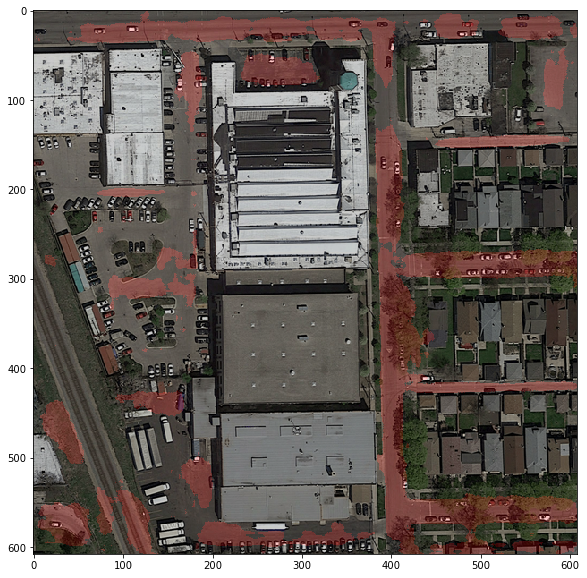

In [11]:
print_image_test("test_set_images/", 1, model, do_prep=True)

In [22]:
def create_submission_UNet(test_path, model, name_submission, do_preprocessing= False):
    ''' create the submission file for U-Net.
    
    test_set is a list of images'''
    
    # preprocessing
    test_set = Testset(test_path, 50, do_prep = do_preprocessing, normalize=True)
    
    test_loader = tc.utils.data.DataLoader(test_set,batch_size=10)
    model.eval()
    
    
   
    if tc.cuda.is_available():
        model.cuda()
    
    list_of_mask = []
    for test,_ in tqdm(test_loader):
        
        if tc.cuda.is_available():
            tc.cuda.empty_cache()
            test = test.cuda()
        test = model(test.view(-1,test_set.get_features(),608,608))
        test = test.cpu()
        list_of_mask.append(test)
    mask = tc.cat(list_of_mask, dim = 0)
    
    mask = (mask.detach().numpy() > 0.5)*1
    list_of_names= []
    for i in range(test_set.__len__()):
        plt.imsave( "prediction_"+str(i+1)+".png", mask[i], cmap = matplotlib.cm.gray)
        list_of_names.append("prediction_"+str(i+1)+".png")
    masks_to_submission(name_submission, *list_of_names)

In [15]:
# Loaded a set of images
root_dir_test = "test_set_images/"
imgs_test = []
for l in range(1,51):
    dir_test = root_dir_test + 'test_'+str(l)+'/'
    files_test = os.listdir(dir_test)
    img_test = load_image(dir_test + files_test[0])
    imgs_test.append(img_test)

In [23]:
create_submission_UNet("test_set_images/", model, 'third_submission.csv', do_preprocessing= True)

100%|██████████| 5/5 [2:18:21<00:00, 1660.30s/it]


NameError: name 'N' is not defined

In [ ]:
n=90*3
N=len(imgs)
train_imgs=imgs[0:n]
train_mask=gt_imgs[0:n]
test_imgs=imgs[n:N]
test_mask = gt_imgs[n:N]


In [ ]:
temp=concatenate_images(train_imgs[3], train_mask[3])
plt.figure(figsize=(10, 10))
plt.imshow(temp)

In [ ]:
? tc.nn.Dropout

In [ ]:
print(len(train_mask))

In [ ]:
print(len(test_imgs),N-n)

In [ ]:
# prepare input data 
w=16
h=16
train_sub_images=[img_crop(train_imgs[i], w, h) for i in range(n)]
train_mask_label=[img_crop(train_mask[i],w,h) for i in range(n)]
train_mask_label=from_mask_to_vector(train_mask_label,0.3)
test_sub_images=[img_crop(test_imgs[i], w, h) for i in range(N-n)]
#test_mask_label=[img_crop(train_mask[n+i],w,h) for i in range(n)]
#test_mask_label=from_mask_to_vector(test_mask_label)


In [ ]:
? Image.fromarray

In [ ]:
print((1*train_mask_label).sum()/len(train_mask_label))

In [ ]:
print(len(train_sub_images[0]))

In [ ]:
train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
test_sub_images = transform_subIMG_to_Tensor(test_sub_images)

In [ ]:
# normalize data
mean = train_sub_images.mean()
std = train_sub_images.std()
train_sub_images = (train_sub_images-mean)/std
train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
#print(train_sub_images[-1]-train_sub_images[-2])
for l in range(n):
    new_indices= np.random.permutation(len(train_mask_label))
    train_sub_images=train_sub_images[new_indices]
    train_mask_label=train_mask_label[new_indices]
#print(train_sub_images[0]-train_sub_images[1])
#train_sub_images.requires_grad_(True)

In [ ]:
 ? tc.Tensor.narrow

In [ ]:
print(train_mask_label.sum()/len(train_mask_label))

In [ ]:
model = SimpleNet(0)
lr=1e-4
max_epochs=15
mini_batch_size=1

train_model_Adam( model, train_sub_images, train_mask_label, max_epochs, lr, mini_batch_size)

In [ ]:
print(tc.__version__)

In [ ]:
? tc.mean

In [ ]:
N1=625

In [ ]:
# print the result on a single image
#N1=int(train_sub_images.size(0)/n)
image_test= test_sub_images.narrow(0,43*N1,N1)
image_test=(image_test-mean)/std
mask_array=model(image_test)
#print(mask_array.max())
mask_list=mask_array[:]>0.5
mask_test = label_to_img(400, 400, 16, 16, mask_list)

In [ ]:
# compute F1 score
mask=gt_imgs[n]
#print(mask.sum())
print(calcul_F1(mask, mask_test))

In [ ]:
# overlap images

print_img = make_img_overlay(imgs[n+43], mask_test)
#print_img = make_img_overlay(imgs[n+43], gt_imgs[n+43])
plt.figure(figsize=(10, 10))
plt.imshow(print_img)

In [ ]:
def compute_test_error(test_dataset, test_label, nb_patches, model):
    ''' compute the F1 error made during road segmentation. 
    Exemple: for a 16*16 patch we have that nb_patches=625'''
    model.is_train=False
    mean=test_dataset.mean()
    std= test_dataset.std()
    test_dataset = (test_dataset-mean)/std
    test_output = model(test_dataset)
    w = int(400/np.sqrt(nb_patches))
    F1_error=np.zeros(int(test_dataset.size(0)/nb_patches))
    for i in range(int(test_dataset.size(0)/nb_patches)):
        mask = test_output.narrow(0,i*nb_patches, nb_patches)
        mask = mask.detach().numpy()[:]>0.5
        mask = label_to_img(400, 400, w, w, mask)
        F1_error[i] = calcul_F1(test_label[i], mask)
    plt.figure()
    plt.plot(np.arange(int(test_dataset.size(0)/nb_patches))+1,F1_error)
    plt.xlabel('image')
    plt.ylabel('F1_error')
    F1_mean= np.mean(F1_error)
    return F1_mean
    

In [ ]:
F1=compute_test_error(test_sub_images, test_mask, 625, model)

In [ ]:
print(F1)